In [1]:
# Import libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, lit, avg
from pyspark.sql.types import StringType, FloatType, StructType, StructField
import pyspark.sql.functions as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve
import re
from tqdm import tqdm

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("HomeCredit") \
    .getOrCreate()

# Import dataset from parquet
df = spark.read.load('train.parquet')

# 1. Engineering data

## 1.1. Missing values

In [3]:
# Count missing values in each column
missing_counts = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_df = missing_counts.withColumn('Column', lit('Total')).toPandas().set_index('Column').transpose()
missing_df['Percent'] = (missing_df['Total']*100/df.count()).round(2)
missing_df.sort_values('Total', ascending=False).head(30)

Column,Total,Percent
EXT_SOURCE_1,4360550,53.89
PREV_NFLAG_INSURED_ON_APPROVAL,3442496,42.54
PREV_DAYS_LAST_DUE,3442496,42.54
PREV_DAYS_TERMINATION,3442496,42.54
OCCUPATION_TYPE,2602588,32.16
PREV_AMT_GOODS_PRICE,1861801,23.01
PREV_AMT_ANNUITY,1829413,22.61
BUREAU_DAYS_CREDIT_ENDDATE,683204,8.44
EXT_SOURCE_3,370453,4.58
BUREAU_AMT_CREDIT_SUM,175497,2.17


In [4]:
# Identify string and numeric columns
str_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
num_cols = [x for x in df.columns if x not in str_cols]
idx_cols = [
    'SK_ID_CURR',
    'BUREAU_SK_ID_CURR', 'BUREAU_SK_ID_BUREAU',
    'PREV_SK_ID_CURR', 'PREV_SK_ID_PREV'
]
features = [x for x in num_cols if x not in ['TARGET'] + idx_cols]

## 1.2.  Numerical variables

<b> Correlation matrix

In [5]:
# Calculate correlation with target for each feature
corr_data = []
for var in features:
    correlation = df.stat.corr('TARGET', var)
    corr_data.append([var, correlation])

# Create correlation dataframe
corr_schema = StructType([
    StructField("Variable", StringType()),
    StructField("Correlation", FloatType())
])

corr_df = spark.createDataFrame(corr_data, schema=corr_schema) \
                .withColumn('Absolute', F.abs(col('Correlation')))
# Show correlations ordered by absolute value
corr_df.orderBy('Absolute', ascending=False).show(len(features))

+--------------------+-------------+------------+
|            Variable|  Correlation|    Absolute|
+--------------------+-------------+------------+
|        EXT_SOURCE_3|  -0.17438422|  0.17438422|
|        EXT_SOURCE_2|  -0.14662737|  0.14662737|
|  BUREAU_DAYS_CREDIT|     0.067338|    0.067338|
|          DAYS_BIRTH|   0.06465716|  0.06465716|
|        EXT_SOURCE_1| -0.053362697| 0.053362697|
|DAYS_LAST_PHONE_C...|   0.04581558|  0.04581558|
|REG_CITY_NOT_WORK...|  0.037440337| 0.037440337|
|       DAYS_EMPLOYED|  -0.03494869|  0.03494869|
|   DAYS_REGISTRATION|  0.032477297| 0.032477297|
|REG_CITY_NOT_LIVE...|  0.030003462| 0.030003462|
|     AMT_GOODS_PRICE| -0.029813254| 0.029813254|
|BUREAU_DAYS_CREDI...|  0.028703833| 0.028703833|
|          AMT_CREDIT| -0.020801254| 0.020801254|
|PREV_NFLAG_INSURE...| -0.016091458| 0.016091458|
|        CNT_CHILDREN|  0.015917707| 0.015917707|
|     CNT_FAM_MEMBERS|  0.015748272| 0.015748272|
|    PREV_AMT_ANNUITY| -0.011781979| 0.011781979|


In [6]:
# Select numerical variables with correlation >= 0.01
numvar_col = corr_df.where(col('Absolute') >= 0.01).select('Variable')
chosen_numvar = [numvar_col.collect()[i][0] for i in range(len(numvar_col.collect()))]

In [7]:
# Create correlation heatmap with selected variables
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

corr_columns = ['TARGET'] + chosen_numvar
def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df.na.drop()).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    return pd.DataFrame(result.reshape(-1, len(corr_columns)),
                        columns=corr_columns,
                        index=corr_columns)

corr = correlation_matrix(df, corr_columns)

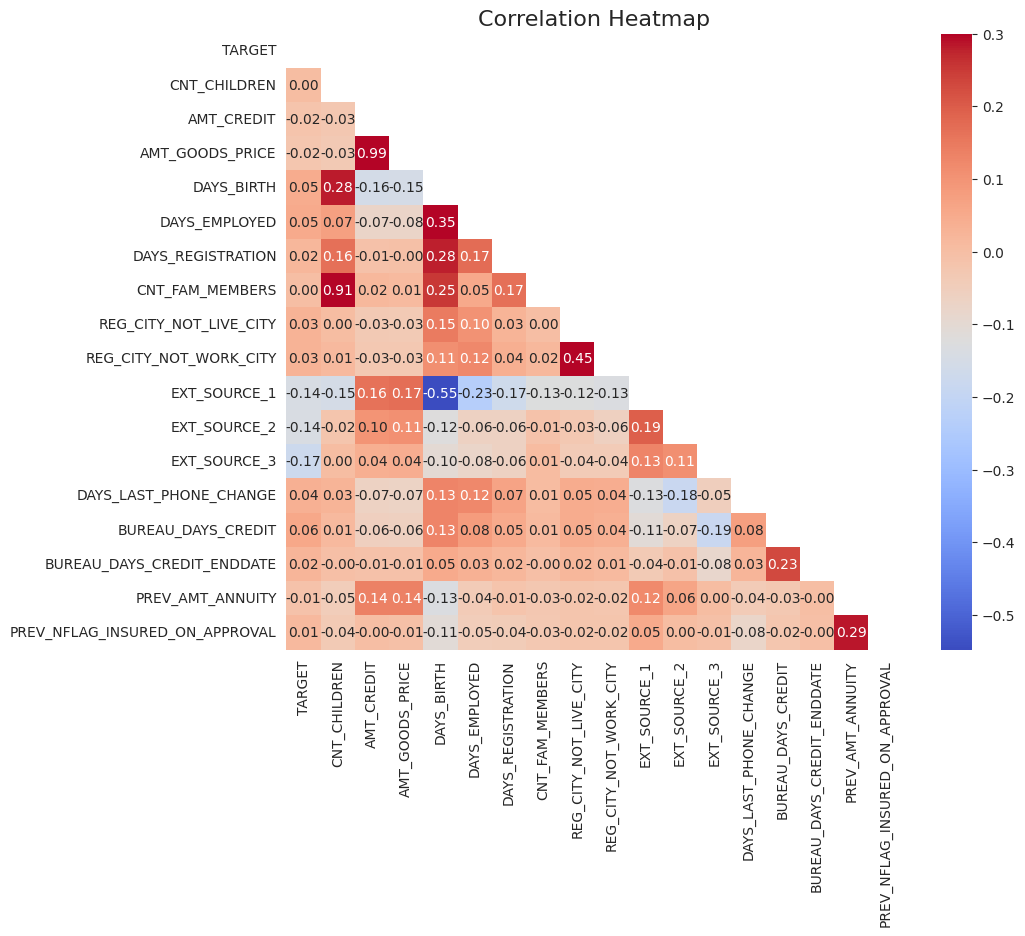

In [8]:
# Plot heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Heatmap", fontsize=16)

## 1.3. Categorical variables

In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

# Index categorical variables
indexers = [StringIndexer(inputCol=col, outputCol='CAT_'+col, handleInvalid="keep").fit(df.na.drop()) for col in str_cols]
pipeline = Pipeline(stages=indexers)
idx_df = pipeline.fit(df.na.drop()).transform(df.na.drop())
cat_cols = ['CAT_'+x for x in str_cols]

In [10]:
# Calculate correlations for categorical variables
corr_cat = []
for var in cat_cols:
    correlation = idx_df.stat.corr('TARGET', var)
    corr_cat.append([var, correlation])

In [11]:
# Create correlation dataframe for categorical variables
cat_corr_df = spark.createDataFrame(corr_cat, schema=corr_schema).na.drop()
cat_corr_df = cat_corr_df.withColumn('Absolute', F.abs(cat_corr_df.Correlation))
cat_corr_df.orderBy('Absolute', ascending=False).show(len(cat_cols))


+--------------------+------------+------------+
|            Variable| Correlation|    Absolute|
+--------------------+------------+------------+
|CAT_NAME_EDUCATIO...|-0.047208134| 0.047208134|
|CAT_NAME_INCOME_TYPE|-0.037655972| 0.037655972|
|CAT_BUREAU_CREDIT...|  0.03424089|  0.03424089|
|CAT_NAME_CONTRACT...| -0.03369867|  0.03369867|
|    CAT_FLAG_OWN_CAR|-0.031940434| 0.031940434|
|CAT_PREV_NAME_CON...| 0.031785283| 0.031785283|
|     CAT_CODE_GENDER|  0.02024206|  0.02024206|
|CAT_NAME_HOUSING_...| 0.015710387| 0.015710387|
|CAT_BUREAU_CREDIT...|0.0149923675|0.0149923675|
|CAT_ORGANIZATION_...| -0.00686677|  0.00686677|
|CAT_NAME_FAMILY_S...|0.0035260892|0.0035260892|
| CAT_OCCUPATION_TYPE|-0.002623034| 0.002623034|
|CAT_PREV_NAME_CLI...| 0.001330584| 0.001330584|
| CAT_FLAG_OWN_REALTY| 5.733867E-4| 5.733867E-4|
+--------------------+------------+------------+



In [12]:
# Select categorical variables with correlation >= 0.01
catvar_col = cat_corr_df.filter(cat_corr_df.Absolute >= 0.01).select('Variable')
chosen_catvar = [catvar_col.collect()[i][0] for i in range(len(catvar_col.collect()))]

# Remove prefix CAT_ to get original column names
chosen_catevar = [re.compile(r"CAT_").sub("", m) for m in chosen_catvar]

## 1.4. Features engineering

In [13]:
# Select relevant features
features = ['TARGET'] + idx_cols + chosen_numvar + chosen_catevar
df_final = df.select(features).fillna(0, subset=chosen_numvar + idx_cols)

<b> All categorical variables, transform by `StringIndexer`

In [14]:
# Index categorical variables with IDX_ prefix
indexer = [StringIndexer(inputCol=col, outputCol='IDX_'+col, handleInvalid="keep").fit(df_final) for col in chosen_catevar]
pipeline = Pipeline(stages=indexer)
dff = pipeline.fit(df_final.na.drop()).transform(df_final.na.drop())

<b> Aggregation

In [15]:
# Prepare feature names for model
str_var = ['IDX_' + x for x in chosen_catevar]
features = ['TARGET'] + idx_cols + chosen_numvar + str_var

In [16]:
# Aggregate features at SK_ID_CURR level
df_agg = dff.groupBy(['SK_ID_CURR']).agg(
    avg(col('TARGET')).alias('TARGET'),
    F.count(col('BUREAU_SK_ID_BUREAU')).alias('NBR_SK_ID_BUREAU'),
    F.count(col('PREV_SK_ID_PREV')).alias('NBR_SK_ID_PREV'),
    avg(col('CNT_CHILDREN')).alias('CNT_CHILDREN'),
    avg(col('AMT_CREDIT')).alias('AMT_CREDIT'),
    avg(col('AMT_GOODS_PRICE')).alias('AMT_GOODS_PRICE'),
    avg(col('DAYS_BIRTH')).alias('DAYS_BIRTH'),
    avg(col('DAYS_EMPLOYED')).alias('DAYS_EMPLOYED'),
    avg(col('DAYS_REGISTRATION')).alias('DAYS_REGISTRATION'),
    avg(col('CNT_FAM_MEMBERS')).alias('CNT_FAM_MEMBERS'),
    avg(col('REG_CITY_NOT_LIVE_CITY')).alias('REG_CITY_NOT_LIVE_CITY'),
    avg(col('REG_CITY_NOT_WORK_CITY')).alias('REG_CITY_NOT_WORK_CITY'),
    avg(col('EXT_SOURCE_1')).alias('EXT_SOURCE_1'),
    avg(col('EXT_SOURCE_2')).alias('EXT_SOURCE_2'),
    avg(col('EXT_SOURCE_3')).alias('EXT_SOURCE_3'),
    avg(col('DAYS_LAST_PHONE_CHANGE')).alias('DAYS_LAST_PHONE_CHANGE'),
    avg(col('BUREAU_DAYS_CREDIT')).alias('M_BUREAU_DAYS_CREDIT'),
    avg(col('BUREAU_DAYS_CREDIT_ENDDATE')).alias('M_BUREAU_DAYS_CREDIT_ENDDATE'),
    avg(col('PREV_AMT_ANNUITY')).alias('M_PREV_AMT_ANNUITY'),
    avg(col('PREV_NFLAG_INSURED_ON_APPROVAL')).alias('M_PREV_NFLAG_INSURED_ON_APPROVAL'),
    avg(col('IDX_NAME_CONTRACT_TYPE')).alias('IDX_NAME_CONTRACT_TYPE'),
    avg(col('IDX_CODE_GENDER')).alias('IDX_CODE_GENDER'),
    avg(col('IDX_FLAG_OWN_CAR')).alias('IDX_FLAG_OWN_CAR'),
    avg(col('IDX_NAME_INCOME_TYPE')).alias('IDX_NAME_INCOME_TYPE'),
    avg(col('IDX_NAME_EDUCATION_TYPE')).alias('IDX_NAME_EDUCATION_TYPE'),
    avg(col('IDX_NAME_HOUSING_TYPE')).alias('IDX_NAME_HOUSING_TYPE'),
    avg(col('IDX_BUREAU_CREDIT_ACTIVE')).alias('M_IDX_BUREAU_CREDIT_ACTIVE'),
    avg(col('IDX_BUREAU_CREDIT_TYPE')).alias('M_IDX_BUREAU_CREDIT_TYPE'),
    avg(col('IDX_PREV_NAME_CONTRACT_TYPE')).alias('M_IDX_PREV_NAME_CONTRACT_TYPE')
)

print(f"Number of aggregated records: {df_agg.count()}")

Number of aggregated records: 249507


# 2. Models

## 2.1 Splitting train test sets

In [17]:
# Split data into training and validation sets (70% train, 30% test)
train, test = df_agg.randomSplit([0.7, 0.3], seed=12345)
print(f"Number of observations in train set: {train.count()}")
print(f"Number of observations in test set: {test.count()}")

Number of observations in train set: 174349
Number of observations in test set: 75158


In [18]:
# Prepare features
input_cols = [x for x in df_agg.columns if x not in ['SK_ID_CURR', 'TARGET']]

# Create feature vectors
assembler = VectorAssembler(inputCols=input_cols, outputCol='features')
final_train = assembler.transform(train)
final_test = assembler.transform(test)

# 2.5. Gradient-Boosted Tree Classifier

In [19]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Initialize and train Gradient Boosted Tree model
GBT = GBTClassifier(
    labelCol="TARGET",
    featuresCol='features',
    maxIter=20,
    maxDepth=5,
    stepSize=0.1,
    seed=42
)
GBT_Model = GBT.fit(final_train.selectExpr('features','TARGET'))

# Make predictions
train_pred = GBT_Model.transform(final_train.selectExpr('features','TARGET'))

# Evaluate model - ROC AUC
evaluator = BinaryClassificationEvaluator(labelCol="TARGET", metricName="areaUnderROC")
ROC_train = evaluator.evaluate(train_pred)

print(f'Training set areaUnderROC: {ROC_train:.4f}')

Training set areaUnderROC: 0.7497


<Figure size 1000x1200 with 0 Axes>

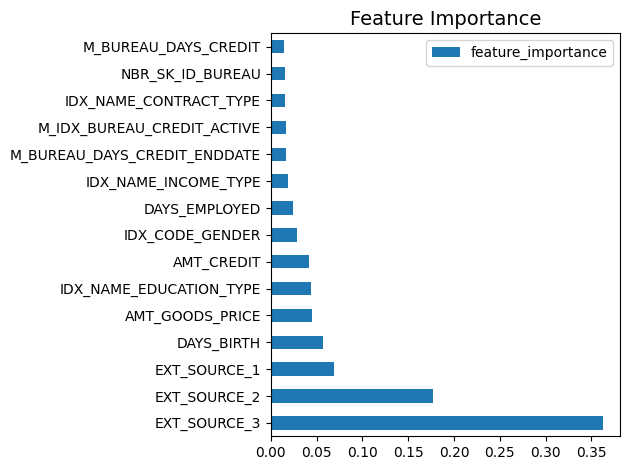

In [20]:
# Calculate feature importance
feature_importances = GBT_Model.featureImportances
feature_names = input_cols

# Plot feature importance
plt.figure(figsize=(10, 12))
importance_df = pd.DataFrame(
    data=list(feature_importances),
    columns=['feature_importance'],
    index=feature_names
)
importance_df = importance_df.sort_values(by='feature_importance', ascending=False)
importance_df.head(30).plot.barh()
plt.title('Feature Importance', fontsize=14)
plt.tight_layout()

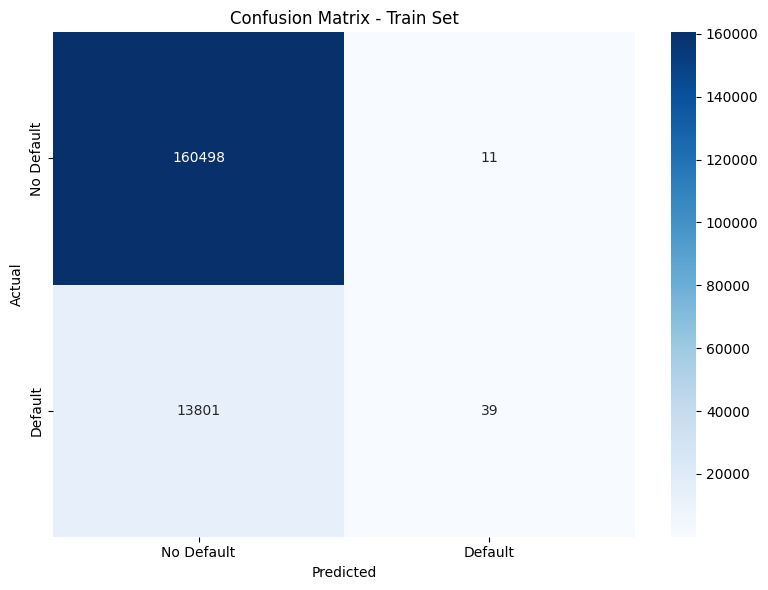

In [21]:
# Calculate confusion matrix
def get_confusion_matrix(predictions):
    # Convert to pandas for easier manipulation
    preds_pd = predictions.select(['TARGET', 'prediction']).toPandas()

    # Generate confusion matrix
    cm = confusion_matrix(preds_pd['TARGET'], preds_pd['prediction'])
    return cm

# Get confusion matrix for train set only
train_cm = get_confusion_matrix(train_pred)

# Plot confusion matrix for train set
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Train Set')
plt.tight_layout()

Intersection threshold: 0.1801
At threshold 0.1801:
Precision: 0.2868
Recall: 0.2868


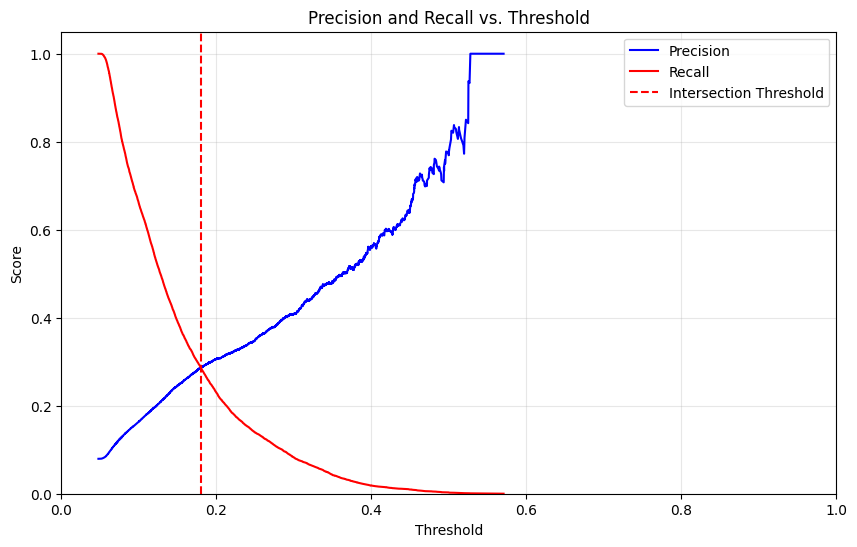

In [22]:
# Convert predictions to pandas for precision-recall curve calculation
train_pandas = train_pred.select(['TARGET', 'probability']).toPandas()

# Extract probability of class 1 (default)
train_pandas['prob_default'] = train_pandas['probability'].apply(lambda x: float(x[1]))

# Calculate precision and recall at different thresholds
precision, recall, thresholds = precision_recall_curve(
    train_pandas['TARGET'],
    train_pandas['prob_default']
)

# Find the threshold where precision and recall curves intersect
# This is approximate - we find the closest points
precision_recall_diff = abs(precision - recall)
intersection_idx = np.argmin(precision_recall_diff)
intersection_threshold = thresholds[intersection_idx] if intersection_idx < len(thresholds) else 0.5

# Plot precision and recall curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b-', label='Precision')
plt.plot(thresholds, recall[:-1], 'r-', label='Recall')
plt.axvline(x=intersection_threshold, color='r', linestyle='--', label='Intersection Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision and Recall vs. Threshold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

print(f"Intersection threshold: {intersection_threshold:.4f}")
print(f"At threshold {intersection_threshold:.4f}:")
print(f"Precision: {precision[intersection_idx]:.4f}")
print(f"Recall: {recall[intersection_idx]:.4f}")

Model Comparison

Model Comparison:
                   Model       AUC
0    Logistic Regression  0.731753
1          Decision Tree  0.500000
2          Random Forest  0.708871
3  Gradient Boosted Tree  0.749677


<ipython-input-23-978de993e4cb>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='AUC', data=model_comparison, palette=colors)


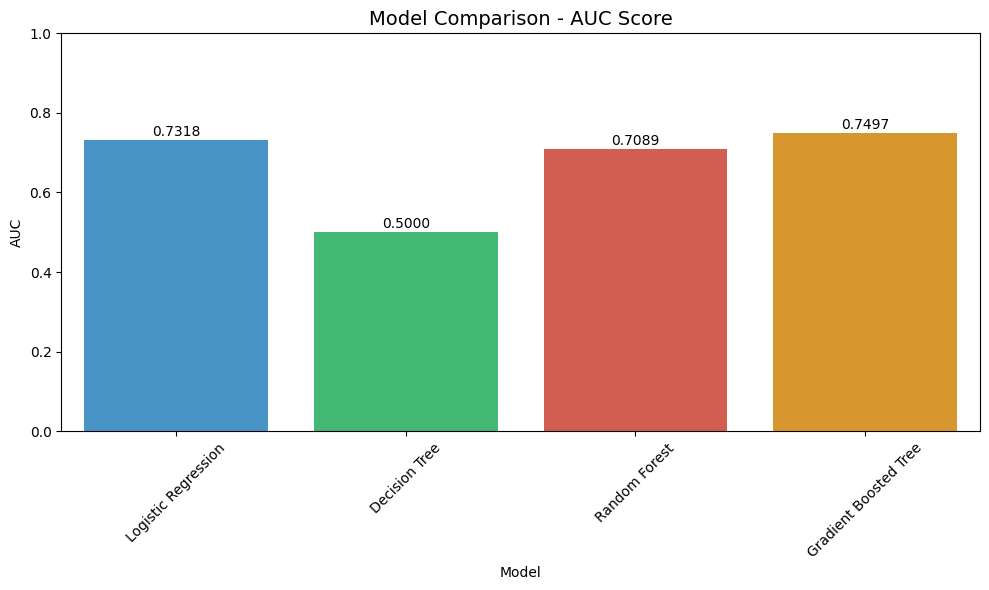

In [23]:
# Compare GBT with other common classification models
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier

# Train Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='TARGET', maxIter=10)
lr_model = lr.fit(final_train.selectExpr('features','TARGET'))
lr_pred = lr_model.transform(final_train.selectExpr('features','TARGET'))
lr_auc = evaluator.evaluate(lr_pred)

# Train Decision Tree model
dt = DecisionTreeClassifier(featuresCol='features', labelCol='TARGET', maxDepth=5)
dt_model = dt.fit(final_train.selectExpr('features','TARGET'))
dt_pred = dt_model.transform(final_train.selectExpr('features','TARGET'))
dt_auc = evaluator.evaluate(dt_pred)

# Train Random Forest model
rf = RandomForestClassifier(featuresCol='features', labelCol='TARGET', numTrees=20, maxDepth=5)
rf_model = rf.fit(final_train.selectExpr('features','TARGET'))
rf_pred = rf_model.transform(final_train.selectExpr('features','TARGET'))
rf_auc = evaluator.evaluate(rf_pred)

# Compare models
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosted Tree'],
    'AUC': [lr_auc, dt_auc, rf_auc, ROC_train]
})

print("Model Comparison:")
print(model_comparison)

# Plot model comparison
plt.figure(figsize=(10, 6))
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
ax = sns.barplot(x='Model', y='AUC', data=model_comparison, palette=colors)
plt.title('Model Comparison - AUC Score', fontsize=14)
plt.ylim(0, 1.0)
plt.xticks(rotation=45)

# Add AUC values on top of bars
for i, v in enumerate(model_comparison['AUC']):
    ax.text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()

In [24]:
# Clean up spark session
spark.stop()